In [42]:
import os
import math
from tqdm import tqdm
import torch
from torch import Tensor, nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

from typing import Union, Tuple, List, Optional, Callable, Any
from torchvision import transforms, utils
from torch.utils.data import DataLoader, TensorDataset

import sys
from pathlib import Path
# Go up one level from training_scripts/ to the project root
project_root = Path().resolve().parent
sys.path.append(str(project_root))

%load_ext autoreload
%autoreload 2


from datasets_local import gaussian_mixture

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import torch
import random
import torch.backends.cudnn as cudnn

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


In [2]:
from models.discrete_diffusion.mdm import MaskedDiffusion
from models.discrete_diffusion.utils.parametrizations import (
    subs_parametrization,
    subs_parametrization_continuous,
)
from models.denoising_models.mlp import MLP

vocab_size = 64
num_categories = vocab_size + 1  #includes the mask category
mask_index = num_categories - 1
input_shape = (2,)
num_timesteps = 100

p_ref = MaskedDiffusion(
    denoising_model=MLP(
        input_shape=input_shape,
        num_categories=num_categories,
        embed_dim=64,
        hidden_dim=64,
        encode_time=False,
        n_hidden_layers=2,
        probs_parametrization_fn=subs_parametrization,
    ),
    num_categories=num_categories,
    input_shape=input_shape,
    mask_index=mask_index,
    masking_schedule="linear",
    num_timesteps=num_timesteps,
    discretization_schedule="linear",
).to(device)

# load model weights
p_ref.load_state_dict(torch.load('../model_weights/mdm_gmm_type1_64.pth'))
p_ref.eval()

MaskedDiffusion(
  (denoising_model): MLP(
    (embedding): Embedding(65, 64)
    (mlp): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): ReLU()
      )
      (3): Linear(in_features=64, out_features=130, bias=True)
    )
  )
)

In [3]:
def compute_rewards(x: Tensor, with_grad=False):
    # x.shape : (B, 2, num_categories)
    
    x0 = torch.arange(0, vocab_size, device=x.device).float() / (vocab_size - 1)
    x1 = torch.arange(0, vocab_size, device=x.device).float() / (vocab_size - 1)
    
    reward_x0 = - ((x0 - 0.5) * 12) ** 2 / 100
    reward_x1 = - ((x1 - 0.5) * 12) ** 2 
    
    reward = (x[:, 0, :-1] * reward_x0 + x[:, 1, :-1] * reward_x1).sum(dim=-1)
    return reward

kl_weight = 1.  

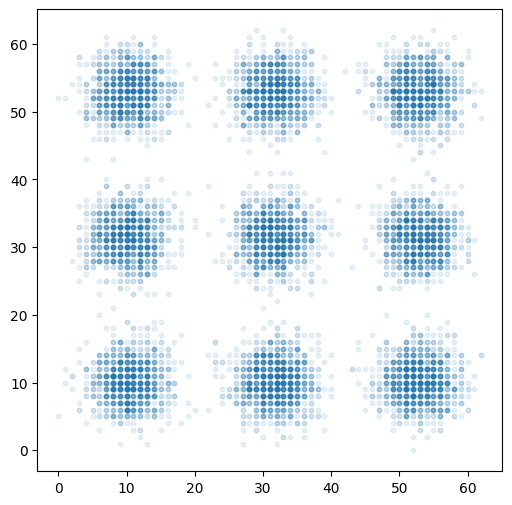

Pre-trained distribution Reward: -11.580293655395508


In [4]:
# Visualize pre-trained model samples
with torch.no_grad():
    pretrained_model_samples = p_ref.sample(num_samples=10000, device=device).cpu().numpy()
plt.figure(figsize=(6, 6))
plt.scatter(pretrained_model_samples[:, 0], pretrained_model_samples[:, 1], s=10, alpha=0.1)
plt.show()

rewards = compute_rewards(F.one_hot(torch.from_numpy(pretrained_model_samples), num_classes=num_categories).float())
pretrained_samples_reward = rewards.mean().item()
print(f"Pre-trained distribution Reward: {pretrained_samples_reward}")

Visualize target distribution

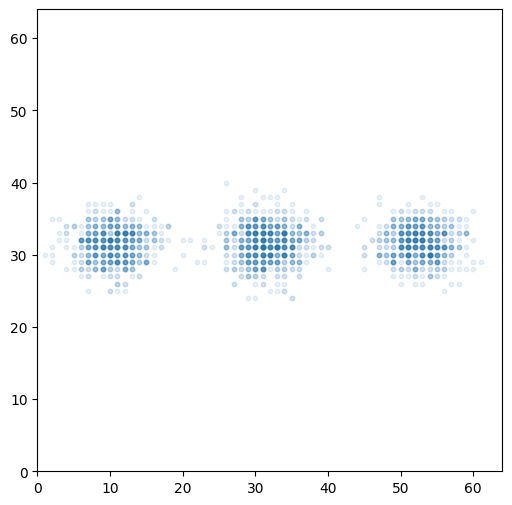

Target Reward: -0.2930627763271332
Diversity: 424


In [5]:
def target_distribution_log_pdf(x, kl_weight):
    reward = compute_rewards(F.one_hot(x, num_classes=num_categories).float())
    return reward / kl_weight

def sample_target_distribution(n_samples, kl_weight):
    samples = gaussian_mixture.generate_samples(type="1", n_grid_points=vocab_size, batch_size=n_samples * 100)
    log_pdf_values = target_distribution_log_pdf(samples, kl_weight)
    indices = torch.distributions.Categorical(logits=log_pdf_values).sample((n_samples,))
    return samples[indices]

target_samples = sample_target_distribution(2000, kl_weight)

plt.figure(figsize=(6, 6))
plt.scatter(target_samples[:, 0], target_samples[:, 1], s=10, alpha=0.1)
plt.xlim(0, vocab_size)
plt.ylim(0, vocab_size)
plt.show()

target_rewards = compute_rewards(F.one_hot(target_samples, num_classes=num_categories).float())
target_samples_reward = target_rewards.mean().item()
print(f"Target Reward: {target_samples_reward}")
target_samples_diversity = np.unique(target_samples, axis=0).shape[0]
print(f"Diversity: {target_samples_diversity}")

Load model to optimize

Divergence logic

In [34]:
def calculate_loss(
    r : torch.Tensor,
    tilde_r: torch.Tensor,
    f_divergence: str = "forward-KL",
    alpha: Optional[float] = None,
    softmax_dim=-1,
) -> torch.Tensor:
    log_w = F.log_softmax(r, dim=softmax_dim)
    log_tilde_w = F.log_softmax(tilde_r, dim=softmax_dim)
    w = log_w.exp()
    tilde_w = log_tilde_w.clamp_min(-100).exp()
    if f_divergence == "forward-KL":
        loss = w * (log_w - log_tilde_w)
    elif f_divergence == "reverse-KL":
        loss = tilde_w * (log_tilde_w - log_w)
    elif f_divergence == "jeffrey":
        loss = (w - tilde_w) * (log_w - log_tilde_w)
    elif f_divergence == "square-hellinger":
        loss = (w.sqrt() - tilde_w.sqrt()) ** 2
    elif f_divergence == "jensen-shannon":
        loss = 0.5 * (
            w * (torch.log(2 * w) - torch.log(w + tilde_w)) +
            tilde_w * (torch.log(2 * tilde_w) - torch.log(w + tilde_w))
        )
    elif f_divergence == "alpha-divergence":
        assert alpha is not None, "Value of alpha should be provided for alpha-divergence."
        # loss_og = (1 / (alpha * (alpha - 1))) * (
        #     tilde_w * ((w / tilde_w) ** (1 - alpha) - (1 - alpha) * (w / tilde_w) - alpha)
        # )
        # Equivalent loss formula without division by zero problem of the original formula
        loss = (1 / (alpha * (alpha - 1))) * (
            (w ** (1 - alpha)) * (tilde_w ** alpha) - (1 - alpha) * w - alpha * tilde_w
        )
    else:
        raise ValueError(f"{f_divergence} is not supported.")
    return loss

In [82]:
q_phi = MaskedDiffusion(
    denoising_model=MLP(
        input_shape=input_shape,
        num_categories=num_categories,
        embed_dim=64,
        hidden_dim=64,
        encode_time=False,
        n_hidden_layers=2,
        probs_parametrization_fn=subs_parametrization,
    ),
    num_categories=num_categories,
    input_shape=input_shape,
    mask_index=mask_index,
    masking_schedule="linear",
    num_timesteps=num_timesteps,
    discretization_schedule="linear",
).to(device)

# load model weights
q_phi.load_state_dict(torch.load('../model_weights/mdm_gmm_type1_64.pth'))
q_phi.eval()

MaskedDiffusion(
  (denoising_model): MLP(
    (embedding): Embedding(65, 64)
    (mlp): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): ReLU()
      )
      (3): Linear(in_features=64, out_features=130, bias=True)
    )
  )
)

In [83]:
batch_size = 1000
lr = 0.1
optimizer = torch.optim.Adam(q_phi.parameters(), lr=lr)
num_epochs = 100
batches_per_epoch = 100
patience = 5
f_divergence = "forward-KL"
alpha = 0.8

os.makedirs('../model_weights/importance_weighted_loss/mdm_gmm1', exist_ok=True)
ckpt_path = f'../model_weights/importance_weighted_loss/mdm_gmm1/{f_divergence}.pth'
if f_divergence == "alpha-divergence":
    ckpt_path = f'../model_weights/importance_weighted_loss/mdm_gmm1/{f_divergence}_{alpha}.pth'

In [84]:
loss_trace = []
reward_trace = []

100%|██████████| 100/100 [01:57<00:00,  1.18s/it]


Epoch 1/100,  Loss: 0.006151240930194035


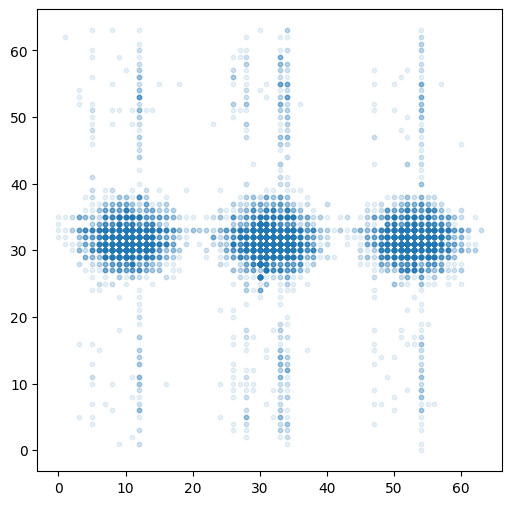

Reward: -1.2929037809371948
Saved model weights.


100%|██████████| 100/100 [01:56<00:00,  1.17s/it]


Epoch 2/100,  Loss: 0.005699342570733279


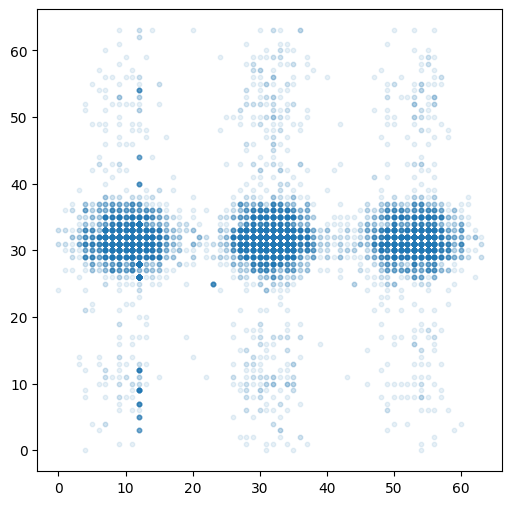

Reward: -1.5024676322937012
Saved model weights.


100%|██████████| 100/100 [02:09<00:00,  1.30s/it]


Epoch 3/100,  Loss: 0.004800562912132591


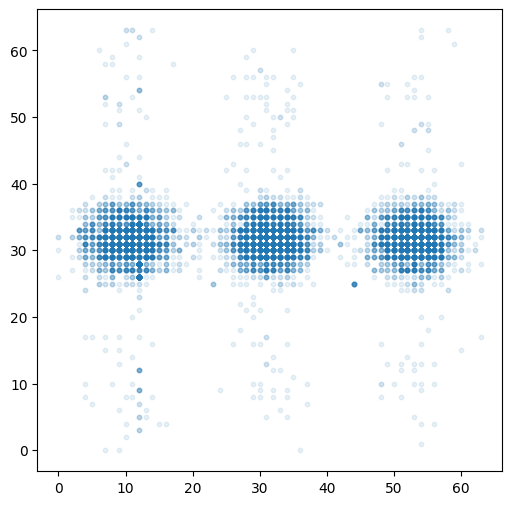

Reward: -0.7210731506347656
Saved model weights.


100%|██████████| 100/100 [02:08<00:00,  1.29s/it]


Epoch 4/100,  Loss: 0.004638371078763157


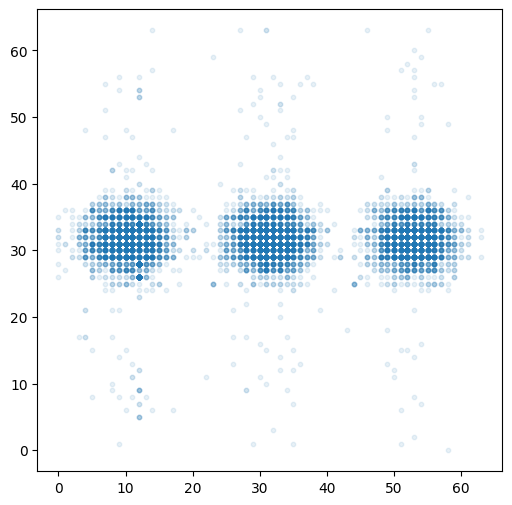

Reward: -0.5963975787162781
Saved model weights.


100%|██████████| 100/100 [02:09<00:00,  1.29s/it]


Epoch 5/100,  Loss: 0.004973759343847632


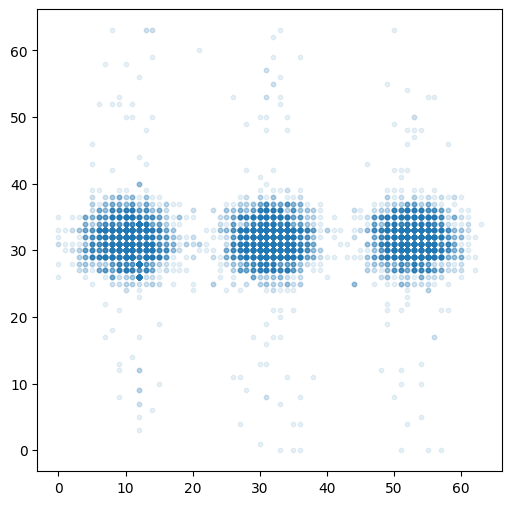

Reward: -0.5776383280754089


100%|██████████| 100/100 [02:24<00:00,  1.45s/it]


Epoch 6/100,  Loss: 0.004521882606204599


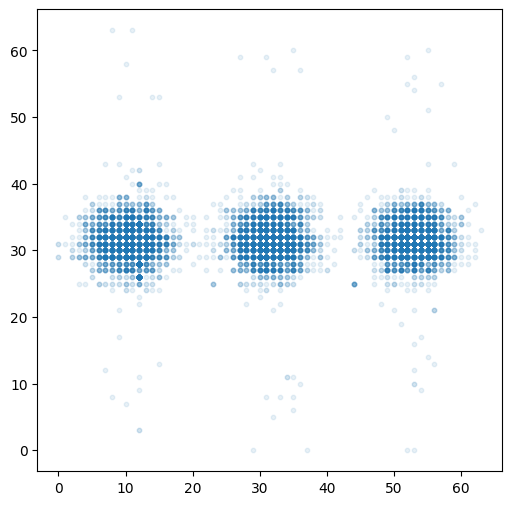

Reward: -0.47628799080848694
Saved model weights.


100%|██████████| 100/100 [04:01<00:00,  2.41s/it]


Epoch 7/100,  Loss: 0.004552441998384893


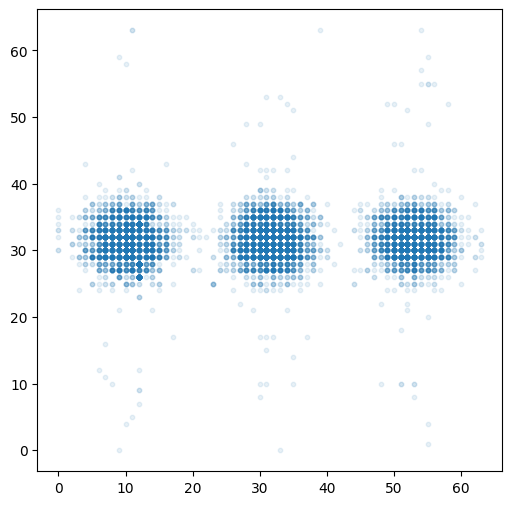

Reward: -0.4765402376651764


100%|██████████| 100/100 [02:42<00:00,  1.62s/it]


Epoch 8/100,  Loss: 0.005287963969167322


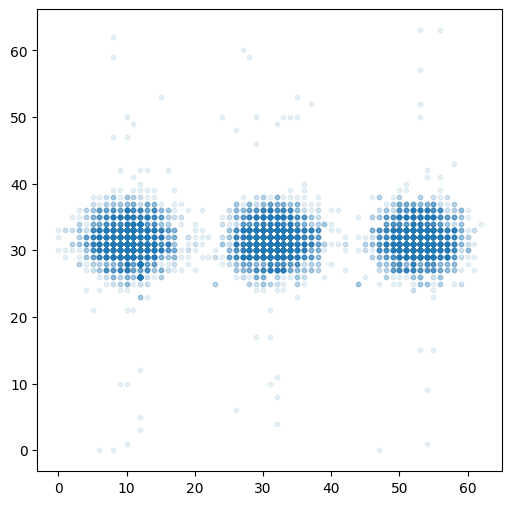

Reward: -0.4337657690048218


 33%|███▎      | 33/100 [00:55<01:53,  1.69s/it]


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [85]:
L = math.prod(q_phi.input_shape)

# Training loop
for epoch in range(num_epochs):
    total_epoch_loss = 0.0
    for batch_idx in tqdm(range(batches_per_epoch)):
        q_phi.train()
        
        q_phi_z0_given_zt_list = torch.zeros(batch_size, q_phi.num_timesteps, L, q_phi.num_categories, device=device)
        p_ref_z0_given_zt_list = torch.zeros(batch_size, q_phi.num_timesteps, L, q_phi.num_categories, device=device)
        
        q_phi_log_joint_probs = torch.zeros(batch_size, device=device)
        p_ref_log_joint_probs = torch.zeros(batch_size, device=device)
        
        beta_ts = torch.zeros(q_phi.num_timesteps, device=device)
        
        # Generate batch_size samples from q_phi
        z_t = torch.full((batch_size, L), q_phi.mask_index, device=device) # Intialize with all masks
        for i in range(q_phi.num_timesteps, 0, -1):
            q_phi_zs_given_zt, q_phi_z0_given_zt = q_phi.sample_step(
                F.one_hot(z_t, num_classes=q_phi.num_categories).float(), i, device
            )
            q_phi_z0_given_zt_list[:, i - 1] = q_phi_z0_given_zt
            with torch.no_grad():
                p_ref_zs_given_zt, p_ref_z0_given_zt = p_ref.sample_step(
                    F.one_hot(z_t, num_classes=q_phi.num_categories).float(), i, device
                )
            p_ref_z0_given_zt_list[:, i - 1] = p_ref_z0_given_zt
            
            # Also save beta_t
            t = p_ref.discrete_time_scheduler.discrete_time(i).to(device)
            alpha_t = p_ref.scheduler.alpha(t)
            beta_t = kl_weight / (1 - alpha_t)
            beta_ts[i - 1] = beta_t
            
            # Create distributions
            q_phi_zs_given_zt_dist = torch.distributions.Categorical(probs=q_phi_zs_given_zt)
            p_ref_zs_given_zt_dist = torch.distributions.Categorical(probs=p_ref_zs_given_zt)
            
            # Sample z_s from q_phi's dist
            z_s = q_phi_zs_given_zt_dist.sample()
            
            # Update joint probs (detach to cut gradient flow to joint probabilities, used for importance weights)
            q_phi_log_joint_probs += q_phi_zs_given_zt_dist.log_prob(z_s).sum(dim=1).detach()
            p_ref_log_joint_probs += p_ref_zs_given_zt_dist.log_prob(z_s).sum(dim=1).detach()
            
            # Update z_t for next loop
            z_t = z_s
            
        z0_samples = z_t.reshape(batch_size, *q_phi.input_shape)
        # Sanity check - the final sample should not have any masked tokens
        assert torch.all(z0_samples != q_phi.mask_index)
        
        # Calculate r
        with torch.no_grad():
            r = compute_rewards(F.one_hot(z0_samples, num_classes=num_categories).float()) # Shape (batch_size,)
            r = r.unsqueeze(1).expand(batch_size, q_phi.num_timesteps)
            
        # Calculate r_tilde
        q_phi_z0_given_zt_dist = torch.distributions.Categorical(probs=q_phi_z0_given_zt_list)
        p_ref_z0_given_zt_dist = torch.distributions.Categorical(probs=p_ref_z0_given_zt_list)
        tilde_r = beta_ts * (
            q_phi_z0_given_zt_dist.log_prob(
                z0_samples.reshape(batch_size, L).unsqueeze(1).expand(batch_size, q_phi.num_timesteps, L)
            ).sum(dim=-1) -
            p_ref_z0_given_zt_dist.log_prob(
                z0_samples.reshape(batch_size, L).unsqueeze(1).expand(batch_size, q_phi.num_timesteps, L)
            ).sum(dim=-1)
        ) # Shape (batch_size, num_timesteps)
        
        # softmax is on the batch dimension
        loss = calculate_loss(r, tilde_r, f_divergence=f_divergence, alpha=alpha, softmax_dim=0) # Shape (batch_size, num_timesteps)
        loss = loss.mean(dim=1)  # Average over timesteps # Shape (batch_size, )
        
        # calculate importance weights
        importance_weights = torch.exp(p_ref_log_joint_probs - q_phi_log_joint_probs)  # Shape (batch_size, )
        loss = (importance_weights * loss).sum(dim=0)
        loss = loss / importance_weights.sum()  # Normalize by the sum of importance weights
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_epoch_loss += loss.item()
        # print("Loss: ", loss.item())
    
    q_phi.eval()
    avg_loss = total_epoch_loss / batches_per_epoch
    print(f"Epoch {epoch+1}/{num_epochs},  Loss: {avg_loss}")
    loss_trace.append(avg_loss)
    
    with torch.no_grad():
        model_samples = q_phi.sample(num_samples=10000, device=device).cpu()     
    plt.figure(figsize=(6, 6))
    plt.scatter(model_samples[:, 0], model_samples[:, 1], s=10, alpha=0.1)
    plt.show()

    rewards = compute_rewards(F.one_hot(model_samples, num_classes=num_categories).float())
    print(f"Reward: {rewards.mean().item()}")
    reward_trace.append(rewards.mean().item())
    
    if loss_trace[-1] == min(loss_trace):
        # store model weights
        torch.save(q_phi.state_dict(), ckpt_path)
        print("Saved model weights.")
        
    if min(loss_trace) < min(loss_trace[-patience:]):
        break
    

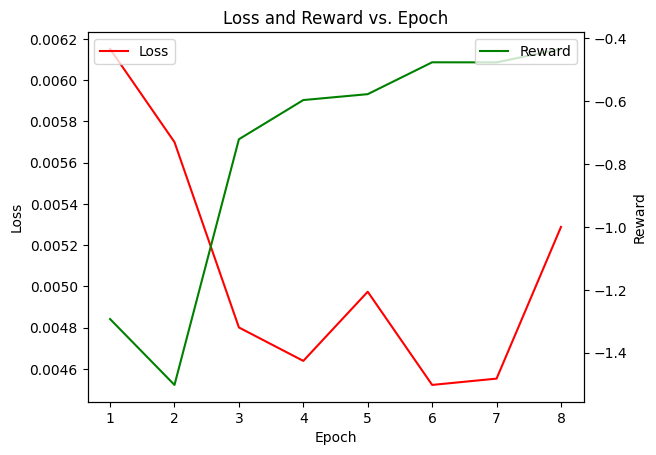

In [86]:
import matplotlib.pyplot as plt

# loss_trace and reward_trace are 1D lists (or 1D arrays) of the same length
epochs = range(1, len(loss_trace) + 1)

fig, ax1 = plt.subplots()
ax1.plot(epochs, loss_trace, label='Loss', color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2 = ax1.twinx()
ax2.plot(epochs, reward_trace, label='Reward', color='green')
ax2.set_ylabel('Reward')

# place legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Loss and Reward vs. Epoch')
plt.show()